In [1]:
import os, re, sys, json
from collections import defaultdict
import numpy as np, pandas as pd
import _config
reload (_config)
from _config import SHE3202_FQ_FILES, EXP_DESIGN_2901, OLIGO_LIBRARY, SHE3202_DIR, A_BC_OLIGOS_OUT


In [2]:
##
# Locality sensitive hashing
##

global names_targets 
names_targets = dict([(k,v.Sequences) for k,v in OLIGO_LIBRARY.iterrows()])

def build_targets_better_lsh():
  global names_targets
  lsh_dict = defaultdict(list)
  for nm in names_targets:
    target = names_targets[nm]
    kmers = get_lsh_kmers(target)
    for kmer in kmers:
      lsh_dict[kmer].append(nm)
  return lsh_dict

def get_lsh_kmers(target):
  kmer_len = 10
  kmers = []
  for idx in range(len(target) - kmer_len):
    kmer = target[idx : idx + kmer_len]
    kmers.append(kmer)
  return kmers

def find_best_designed_target(read, lsh_dict):
  kmers = get_lsh_kmers(read)
  scores = dict()
  for kmer in kmers:
    for exp in lsh_dict[kmer]:
      if exp not in scores:
        scores[exp] = 0
      scores[exp] += 1

  if len(scores) == 0:
    return []

  sorted_scores = sorted(scores, key = scores.get, reverse = True)
  best_score = scores[sorted_scores[0]]
  secondbest_score = scores[sorted_scores[1]]
  # cand_idxs = []
  # for exp in sorted_scores:
  #   if scores[exp] + 5 < best_score:
  #     break
  #   cand_idxs.append(exp)
  cand_idxs = sorted_scores[0]
  return cand_idxs, best_score,secondbest_score

In [13]:
#scan the fastq file for reads
#OUTPUT
#  matched_reads -- a list of all matched forward reads
#  qualities -- quality scores for all matched reads
num_tot = 0
num_bad_q = 0
matched_reads = []
qualities = []
notfound = 0
num_valerr = 0

umis_by_oligo = dict()
poorly_aligned = 0

#print difflib.get_close_matches(oligo_seq, OLIGO_LIBRARY.Sequences.values[:100] , n=1, cutoff=.01)

def featurize0(s):
    return np.array([s.count(l) for l in "ATGC"],dtype=np.float)

def featurize(s):
    return np.array([{"A":0.0,"T":1.0,"G":2.0,"C":3.0,"N":4.0}[l] for l in s])

def featurize_dict(s):
    return dict([(l,s.count(l)) for l in "ATGC"])
def selectbest(query, subjects, subject_features):
    qcounts0 = featurize(query)
    norm = np.sqrt(np.sum(qcounts0**2))
    qcounts = qcounts0 / norm
    dotprod = np.sum(qcounts*subject_features,1)
    second ,cand = np.argsort(dotprod)[-2:]
    
    return cand, dotprod[cand], dotprod[second]


lsh_dict = build_targets_better_lsh()

   

subject_features0 = np.array([featurize(s) for s in  OLIGO_LIBRARY.Sequences.values]) / len(OLIGO_LIBRARY.Sequences[0])
subject_features = subject_features0 / np.sqrt(np.sum(subject_features0**2,1))[:,np.newaxis]
subjects = OLIGO_LIBRARY.Sequences.values

umi_oligo_pairs = set({})
flush_number = 0

umi_oligo_counts = {}
#loop over all files (R1 only)
for lane in [1,2,3,4]:
    i = -1
    r1fn =os.path.join(SHE3202_DIR,"SHE3202-STARRseqNextera-PE_AHGTJWAFXY_S1_L00{0}_R1_001.fastq".format(lane))
    r2fn =os.path.join(SHE3202_DIR,"SHE3202-STARRseqNextera-PE_AHGTJWAFXY_S1_L00{0}_R2_001.fastq".format(lane))
    with open(r1fn) as f1:
      with open(r2fn) as f2:
        print f1
        while 1:
            if i %10000 == 0: print float(i) / 10000
            
            i+=1
            try:
                for j in range(1+4*1000):
                    l1 = f1.next()
                    l2 = f2.next()
            except StopIteration:
                break


            if i % 4 == 0:
                h1 = l1.strip()
                h2 = l2.strip()
            if i % 4 == 1:
                r1 = l1.strip()
                r2 = l2.strip()
            if i % 4 == 3:
                num_tot += 1
                qs1 =l1.strip()
                qs2 =l2.strip()
                
                #...RIGHT NOW, ONLY CHECK R2 FOR QUALITY... R1 TENDS TO STINK. TOO LONG
                quals = [ord(s)-33 for s in qs2]
                if np.mean(quals) < 30:
                      num_bad_q += 1
                      continue
   
                try:
                    oligo_offset = r1.index("TGCACCGG")
                except ValueError,v:
                    notfound+=1
                    continue
                    
                oligo_start = oligo_offset + len("TGCACCGG")
                oligo_seq = r1[oligo_start:oligo_start+150]
                
                r2_consensus = "AATTCGTCGA"
                try:
                     umi_offset = r2.index(r2_consensus)
                except ValueError:
                    notfound+=1
                    continue
                umi_start = umi_offset + len(r2_consensus)
                umi_seq = r2[umi_start:umi_start + 15]
                #best_oligo,score,secondbest = selectbest(oligo_seq,subjects,subject_features)
                try:
                    best,score2,secondbest_score2 = find_best_designed_target(oligo_seq,lsh_dict)
                except ValueError:
                    num_valerr+=1
                    continue
                    
                if score2 < 100 or ( score2-secondbest_score2) <10:
                    poorly_aligned += 1
                else:
                    #umi_oligo_pairs.add((umi_seq,best))
                    #print score2, secondbest_score2
                    #break
                    umi_oligo_counts[(umi_seq,best)]= umi_oligo_counts.get((umi_seq,best),0)+1
                


<open file '/cluster/bh0085/shortreads/190206_NS500413_0539_AHGTJWAFXY/Data/Intensities/BaseCalls/NGEI036/SHE3202A1/SHE3202-STARRseqNextera-PE_AHGTJWAFXY_S1_L001_R1_001.fastq', mode 'r' at 0x7fb0c9a4ded0>
0.0
1.0
2.0
3.0
4.0
<open file '/cluster/bh0085/shortreads/190206_NS500413_0539_AHGTJWAFXY/Data/Intensities/BaseCalls/NGEI036/SHE3202A1/SHE3202-STARRseqNextera-PE_AHGTJWAFXY_S1_L002_R1_001.fastq', mode 'r' at 0x7fb0c9a4d5d0>
0.0
1.0
2.0
3.0
4.0
<open file '/cluster/bh0085/shortreads/190206_NS500413_0539_AHGTJWAFXY/Data/Intensities/BaseCalls/NGEI036/SHE3202A1/SHE3202-STARRseqNextera-PE_AHGTJWAFXY_S1_L003_R1_001.fastq', mode 'r' at 0x7fb0c87bc0c0>
0.0
1.0
2.0
3.0
4.0
<open file '/cluster/bh0085/shortreads/190206_NS500413_0539_AHGTJWAFXY/Data/Intensities/BaseCalls/NGEI036/SHE3202A1/SHE3202-STARRseqNextera-PE_AHGTJWAFXY_S1_L004_R1_001.fastq', mode 'r' at 0x7fb0c9a4df60>
0.0
1.0
2.0
3.0
4.0


In [14]:
print notfound
print poorly_aligned
print num_tot
print num_bad_q
print len(umi_oligo_counts)


print len(umi_oligo_counts) + notfound + poorly_aligned + num_bad_q
print num_tot
print num_valerr

11954
4497
40912
7622
16819
40892
40912
0


In [11]:
print notfound
print poorly_aligned

124610
43445


(array([1.61879e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.25200e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.20000e+01]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

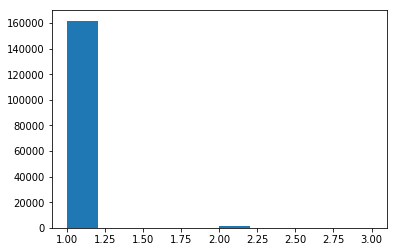

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(umi_oligo_counts.values())

In [ ]:
print "hi"

In [ ]:
print num_tot
print poorly_aligned
print num_bad_q
print notfound

In [195]:
#print len(set(e[0] for e in umi_oligo_counts))
#print len(set(e[1] for e in umi_oligo_counts))

#set(v for v in umi_oligo_counts.values())
#umi_oligo_counts.keys()[0]

#":".join(umi_oligo_counts.keys()[0])

#umi_oligo_counts.keys()[0]
#poorly_aligned

len(umi_oligo_pairs)

16901137

In [202]:
list(umi_oligo_pairs)[0]

('TGGCGGTGGGGGGGG', 9959)

In [5]:
A_BC_OLIGOS_OUT

NameError: name 'A_BC_OLIGOS_OUT' is not defined

In [230]:
with open(A_BC_OLIGOS_OUT, "w") as f:
    f.write("\n".join(["bc,oligo"]+["{0}, {1}".format(u,o) for u,o in list(umi_oligo_pairs )]))

In [222]:
bc_oligos = list(umi_oligo_pairs)
bcs = [e[0] for e in bc_oligos]
oligos = [e[1] for e in bc_oligos]
df = pd.DataFrame([pd.Series(bcs, name="bc"), pd.Series(oligos,name="oligoid")])



In [219]:
import pandas as pd
positive_controls = pd.read_csv("../data/starrseq_transcript_positive_control.csv")


In [231]:
df

,0,1,2,3,4,5,6,7,8,9,...,16901127,16901128,16901129,16901130,16901131,16901132,16901133,16901134,16901135,16901136
bc,TGGCGGTGGGGGGGG,TGGCGACCGGCCGAG,ATTTGGAGGTGGGGA,GCTTTCATCTCTGAC,GTGGCAAGGTTCAAA,GGATATAAATCGTGG,TCTGATATTTGCGGT,CGACGCATAGTTTCC,CCCTCGGGGCCGATG,TAATAGCTCGCGCGT,...,ACACAACCGCACGCA,TGTTAGCTTCTGCTC,TTGTACTCCTGGTTA,TTTTTCGAGTGTGGC,GTTTACGATCAGTGG,ACGAGCGTCAACGAG,ACGGTAGCTGCGGTG,GCTAGGACAGAGTCG,GGAACACCGGGAATG,ATGTGAGTGGGCGGC
oligoid,9959,8117,5589,7886,7512,2268,1381,421,687,558,...,687,9433,930,1389,482,9512,4912,310,1990,6457


In [221]:
len(positive_controls)

66

In [2]:
len(positive_controls)

NameError: name 'positive_controls' is not defined

In [218]:
umi_oligo_counts
print num_bad_q
print num_tot
print notfound
poorly_aligned


30393805
163697739
41052358


16502676